In [17]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
# from rdkit.Chem.Descriptors import *
import rdkit.Chem.Descriptors as desc
import rdkit.Chem.Lipinski as lip
import rdkit.Chem.Crippen as crip
import pandas as pd
from rdkit.Chem import PandasTools

from scipy.stats import zscore

IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

# Testing descriptors

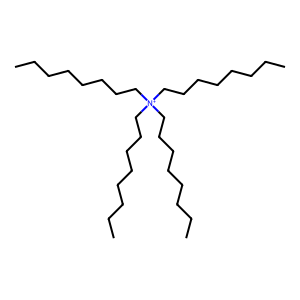

In [18]:
# I randonly chose a molecule from the dataset
# Line 247: CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC	144208226	Active
m = Chem.MolFromSmiles('CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC')
Draw.MolToImage(m)

## Feature selection

### Set 1: Based on Lipinski's rules

**Lipinski's rules of 5 for orally administerred drug.** The rule of 5 indicates that poor absorption is more likely to occur when there are more than 
1. 5 hydrogen-bond donors, 
2. 10 (5 × 2) hydrogen-bond acceptors, 
3. a molecular weight greater than 500 (5 × 100), and 
4. a calculated Log P (cLogP) greater than 5.

In [19]:
set1 = [
    # rule 1: hydrogen bond donors
    (lip.NumHDonors, 'HDonors'),
    # rule 2: hydrogen bond acceptors
    (lip.NumHAcceptors, 'HAcceptors'),
    # rule 3: molecular weight
    (desc.ExactMolWt, 'MolWt'),
    # rule 4: Lig P
    (crip.MolLogP, 'LogP'),
]

In [20]:
### load original dataset
df = pd.read_csv("../source_dataset/Curated_AR_TOX21_Dataset.smi", delimiter='\t')
df.head()

,Smiles,Name,Label
0,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,144203733,Active
1,Clc1cc(ccc1NC(=O)c1cc(Cl)ccc1O)[N+](=O)[O-],144203760,Active
2,O=C1CC[C@H]2[C@@H]3CCC4=C(O)C(=O)CC[C@]4(C)[C@...,144207058,Active
3,NC(=O)N1c2ccccc2C=Cc2ccccc12,144203655,Active
4,Oc1cc2CC[C@@H]3[C@H](CC[C@]4(C)[C@H](CC[C@@H]3...,144203554,Active


In [21]:
for func, colname in set1:
    # print(f'{func}')
    df[colname] = df.apply(
        lambda row: func(
            Chem.MolFromSmiles(row['Smiles'])
        ),
        axis=1
    )
    # Z-score normalization
    df[f'{colname}_norm'] = zscore(df[colname])

## State the label as a numerical value
df['Active'] = df.apply(
    lambda row: int(row['Label']=='Active'),
    axis=1
)
df

,Smiles,Name,Label,HDonors,HDonors_norm,HAcceptors,HAcceptors_norm,MolWt,MolWt_norm,LogP,LogP_norm,Active
0,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,144203733,Active,1,-0.130907,3,-0.246070,270.061612,-0.107584,3.25412,0.362149,1
1,Clc1cc(ccc1NC(=O)c1cc(Cl)ccc1O)[N+](=O)[O-],144203760,Active,2,0.565717,4,0.163925,325.986112,0.311344,3.85950,0.680614,1
2,O=C1CC[C@H]2[C@@H]3CCC4=C(O)C(=O)CC[C@]4(C)[C@...,144207058,Active,1,-0.130907,3,-0.246070,302.188195,0.133075,3.97310,0.740375,1
3,NC(=O)N1c2ccccc2C=Cc2ccccc12,144203655,Active,1,-0.130907,1,-1.066060,236.094963,-0.362026,3.38720,0.432157,1
4,Oc1cc2CC[C@@H]3[C@H](CC[C@]4(C)[C@H](CC[C@@H]3...,144203554,Active,1,-0.130907,3,-0.246070,396.266445,0.837810,6.13050,1.875293,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4497,CC(=O)OC(C)COC,144208634,Inactive,0,-0.827531,3,-0.246070,132.078644,-1.141207,0.58440,-1.042279,0
4498,Oc1ccc2OCOc2c1,144208409,Inactive,1,-0.130907,3,-0.246070,138.031694,-1.096613,1.12090,-0.760049,0
4499,O=C(OCCOCCOC(=O)C=C)C=C,144208286,Inactive,0,-0.827531,5,0.573920,214.084124,-0.526908,0.46140,-1.106984,0
4500,CS(=O)(=O)c1ccc(cc1)c1cn2ccccc2n1,170466528,Inactive,0,-0.827531,4,0.163925,272.061949,-0.092599,2.40480,-0.084642,0


In [22]:
## Check correlation
df[
    ['HDonors_norm', 'HAcceptors_norm', 'MolWt_norm', 'LogP_norm']
].corr()

,HDonors_norm,HAcceptors_norm,MolWt_norm,LogP_norm
HDonors_norm,1.000000,0.518267,0.396285,-0.394845
HAcceptors_norm,0.518267,1.000000,0.683818,-0.230294
MolWt_norm,0.396285,0.683818,1.000000,0.359711
LogP_norm,-0.394845,-0.230294,0.359711,1.000000


In [24]:
## Write data to file, only the features and the labels
df[
    ['HDonors_norm', 'HAcceptors_norm', 'MolWt_norm', 'LogP_norm']+\
    ['Active']    
].to_csv('set1.csv', index=False)